In [1]:

!pip install kaggle

    


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yassineberdad","key":"2f00d3fdd8ddbfcef3836a443729535d"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
 !kaggle datasets download -d hsankesara/flickr-image-dataset

100% 8.16G/8.16G [05:47<00:00, 27.9MB/s]
100% 8.16G/8.16G [05:47<00:00, 25.2MB/s]


In [5]:
!unzip /content/flickr-image-dataset.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535529555.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356236664.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356318668.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535830521.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5359437945.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361355399.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/53614287.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536147209.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361551308.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536156200.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5362687336.jpg  
  inflating: flickr30k_images/flickr3

In [0]:
import os


In [0]:
train_images_list = os.listdir('/content/flickr30k_images/flickr30k_images/flickr30k_images')

In [0]:
sample_size = 30
train_images_list = train_images_list[:sample_size]

In [42]:
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import random

Instructions for updating:
non-resource variables are not supported in the long term


In [0]:
size = (256, 256)
num_channels = 3

In [0]:
train = np.array([None] * sample_size)
real_images = np.array([None] * sample_size)

In [0]:
j = 0
for i in train_images_list:
    real_images[j] = np.array(plt.imread('/content/flickr30k_images/flickr30k_images/' + i))
    train[j] = np.array(plt.imread('/content/flickr30k_images/flickr30k_images/' + i))
    j += 1

In [0]:
j = 0
for i in train:
    train[j] = cv2.resize(i, size)
    train[j] = train[j].reshape(1, size[0], size[1], num_channels)
    j += 1

In [0]:
train = np.vstack(train[:])

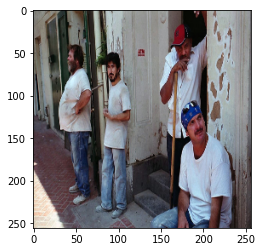

In [16]:
plt.imshow(np.squeeze(train[0]))
plt.show()

In [0]:
import pandas as pd

In [0]:
train_captions = pd.read_csv('/content/flickr30k_images/flickr30k_images/results.csv', delimiter='|')

In [0]:
def get_images_id(names):
    names = [int(x.split('_')[-1].split('.')[0]) for x in names]
    return names

In [0]:
# ids = get_images_id(train_images_list[:sample_size])

In [0]:
train_captions.columns = ['image_name', 'comment_number', 'comment']

In [0]:
def images_map_caption(train_images_list, train_captions):
    caption = []
    for i in train_images_list:
        caption.append(train_captions[train_captions['image_name'] == i]['comment'].iat[0])
    return caption

In [23]:
captions = np.array(images_map_caption(train_images_list, train_captions))
print(captions.shape)

(30,)


In [0]:
import re

In [0]:
start_tag = '<s>'
end_tag = '<e>'

In [0]:
def get_vocab(captions):
    arr = []
    m = captions.shape[0]
    sentence = [None ] * m
    j  = 0
    for i in captions:
        i = re.sub(' +',' ',i)
        i = start_tag + ' ' + i + ' ' + end_tag
        sentence[j] = i.split()
        j += 1
        arr = arr + i.split()
    arr = list(set(arr))
    vocab_size = len(arr)
    j = 0
    fwd_dict = {}
    rev_dict = {}
    j = 0
    for i in arr:
        fwd_dict[i] = j
        rev_dict[j] = i
        j += 1
    return vocab_size, sentence, fwd_dict, rev_dict

In [0]:
vocab_size, sentences, fwd_dict, rev_dict = get_vocab(captions)

In [0]:
from scipy.sparse import csr_matrix
from scipy.sparse import vstack

In [0]:
m = len(sentences)
train_caption = [None] * m
i = 0
for sentence in sentences:
    cap_array = None
    for word in sentence:
        row = [0]
        col = [fwd_dict[word]]
        data = [1]
        if cap_array is None:
            cap_array = csr_matrix((data, (row, col)), shape=(1, vocab_size))
        else:
            cap_array = vstack((cap_array, csr_matrix((data, (row, col)), shape=(1, vocab_size))))
    train_caption[i] = cap_array
    i += 1

In [31]:
train_caption[0].shape

(19, 275)

# Model Design

## Training Model

In [0]:
def create_weights(shape, suffix):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.7), name='W_' + suffix)

def create_biases(size, suffix):
    return tf.Variable(tf.zeros([size]), name='b_' + suffix)

In [0]:
def conv_layer(inp, kernel_shape, num_channels, num_kernels, suffix):
    filter_shape = [kernel_shape[0], kernel_shape[1], num_channels, num_kernels]
    weights = create_weights(shape=filter_shape, suffix=suffix)
    biases = create_biases(num_kernels, suffix=suffix)
    layer = tf.nn.conv2d(input=inp, filter=weights, padding='SAME', strides=[1, 1, 1, 1], name='conv_' + suffix)
    layer += biases
    layer = tf.nn.relu6(layer, name='relu_' + suffix)
    #layer = tf.nn.max_pool(layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2,1], padding= 'SAME')
    return layer



In [0]:
def flatten_layer(layer, suffix):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer = tf.reshape(layer, [-1, num_features], name='flat_' + suffix )
    return layer


In [0]:
def dense_layer(inp, num_inputs, num_outputs, suffix, use_relu=True):
    weights = create_weights([num_inputs, num_outputs], suffix)
    biases = create_biases(num_outputs, suffix)
    layer = tf.matmul(inp, weights) + biases
    layer = tf.nn.relu(layer)
    return layer

In [0]:
def rnn_cell(Win ,Wout, Wfwd, b, hprev, inp):
    h = tf.tanh(tf.add(tf.add(tf.matmul(inp, Win), tf.matmul(hprev, Wfwd)), b))
    out = tf.matmul(h, Wo)
    return h, out

In [0]:
import tensorflow as tf

In [38]:
tf.device("/device:GPU:0")

In [0]:
learning_rate = 0.0001
training_iters = 5000
display_step = 1000
max_sent_limit = 50
num_tests = 12
bridge_size = 1024
keep_prob = 0.3

In [0]:
x_caption = tf.placeholder(tf.float32, [None, vocab_size], name = 'x_caption')
x_inp = tf.placeholder(tf.float32, shape=[1, size[0],size[1],num_channels], name='x_image')
y = tf.placeholder(tf.float32, [None, vocab_size], name = 'x_caption')

In [0]:
Wconv = tf.Variable(tf.truncated_normal([bridge_size, vocab_size], stddev=0.7))
bconv = tf.Variable(tf.zeros([1, vocab_size]))
Wi= tf.Variable(tf.truncated_normal([vocab_size, vocab_size], stddev=0.7))
Wf= tf.Variable(tf.truncated_normal([vocab_size, vocab_size], stddev=0.7))
Wo= tf.Variable(tf.truncated_normal([vocab_size, vocab_size], stddev=0.7))
b = tf.Variable(tf.zeros([1, vocab_size]))

In [0]:
layer_conv1 = conv_layer(inp=x_inp, kernel_shape=(3, 3), num_kernels=32, num_channels=3, suffix='1')
layer_conv2 = conv_layer(inp=layer_conv1, kernel_shape=(3, 3), num_kernels=32, num_channels=32, suffix='2')
maxpool1 = tf.nn.max_pool(layer_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2,1], padding= 'SAME')
layer_conv3 = conv_layer(inp=maxpool1, kernel_shape=(3, 3), num_kernels=64, num_channels=32, suffix='3')
layer_conv4 = conv_layer(inp=layer_conv3, kernel_shape=(3, 3), num_kernels=64, num_channels=64, suffix='4')
maxpool2 = tf.nn.max_pool(layer_conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2,1], padding= 'SAME')
layer_conv5 = conv_layer(inp=maxpool2, kernel_shape=(3, 3), num_kernels=128, num_channels=64, suffix='5')
layer_conv6 = conv_layer(inp=layer_conv5, kernel_shape=(3, 3), num_kernels=128, num_channels=128, suffix='6')
maxpool3 = tf.nn.max_pool(layer_conv6, ksize=[1, 2, 2, 1], strides=[1, 2, 2,1], padding= 'SAME')
layer_conv7 = conv_layer(inp=maxpool3, kernel_shape=(3, 3), num_kernels=256, num_channels=128, suffix='7')
layer_conv8 = conv_layer(inp=layer_conv7, kernel_shape=(3, 3), num_kernels=256, num_channels=256, suffix='8')

In [0]:
flat_layer = flatten_layer(layer_conv8, suffix='9')
#flat_layer = tf.layers.dropout(flat_layer, rate= keep_prob)
dense_layer_1 = dense_layer(inp=flat_layer, num_inputs=262144 , num_outputs=bridge_size, suffix='10')

In [0]:
start_hook = tf.cast(csr_matrix(([1], ([0], [fwd_dict[start_tag]])), shape=(1, vocab_size)).A, tf.float32)
end_hook = tf.cast(csr_matrix(([1], ([0], [fwd_dict[end_tag]])), shape=(1, vocab_size)).A, tf.float32)

In [0]:
hook = tf.slice(x_caption, [0, 0], [1, vocab_size])
h = dense_layer_1
h, out = rnn_cell(Wi ,Wo, Wconv, bconv, h, hook)

In [0]:
def fn(prev, curr):
    h = prev[0]
    curr = tf.reshape(curr, [1, vocab_size])
    h, out = rnn_cell(Wi ,Wo, Wf, b, h, curr)
    return h, out

In [0]:
_, output = tf.scan(fn, x_caption[1:], initializer=(h, out))

In [0]:
output = tf.squeeze(output, axis  = 1)

In [0]:
outputs = tf.concat([out, output], axis = 0)

In [0]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=outputs, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [0]:
pred = tf.nn.softmax(outputs)

In [0]:
# Model evaluation
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

## Predictive Model

In [0]:
out_tensor = tf.TensorArray(dtype=tf.float32, dynamic_size=True, size = 0)

In [0]:
htest = dense_layer_1
htest, out_first = rnn_cell(Wi ,Wo, Wconv, bconv, htest, start_hook)
t = 0
out_ = tf.one_hot(tf.argmax(tf.nn.softmax(out_first), 1), depth=vocab_size)
out_tensor = out_tensor.write(t, out_)
t += 1

In [0]:
def condition(res, h, out_tensor, t):
    return tf.logical_and(tf.logical_not(tf.equal(tf.argmax(res, 1)[0], fwd_dict[end_tag])), tf.less(t, max_sent_limit))

In [0]:
def action(res, h, out_tensor, t):
    h, out = rnn_cell(Wi ,Wo, Wf, b, h, res)
    res = tf.one_hot(tf.argmax(tf.nn.softmax(out), 1), depth=vocab_size)
    out_tensor = out_tensor.write(t, res)
    return res, h, out_tensor, t + 1

In [0]:
_, __, final_outputs, T = tf.while_loop(condition, action, [out_, htest, out_tensor, t])

In [0]:
final_prediction = tf.squeeze(final_outputs.stack())

In [0]:
saver = tf.train.Saver()
init = tf.global_variables_initializer()

# Model Implemetation

After  1000 iterations: Cost =  12.243988370895385 and Accuracy:  29.858197222153347 %
After  2000 iterations: Cost =  8.132013857364655 and Accuracy:  38.254075000683464 %
After  3000 iterations: Cost =  6.00882435242335 and Accuracy:  45.6520431737105 %
After  4000 iterations: Cost =  4.8251620054245 and Accuracy:  50.67109242081642 %
After  5000 iterations: Cost =  3.896366060276826 and Accuracy:  53.5732493797938 %
Optimization finished!
Let's check
(20, 275)
Predicted Caption:-> Two men in the foreground of and construction project are using . to smooth walking paint school peeling from 
Orignal Caption:-> Two men in the foreground of a construction project are using trowels to smooth down dirt , while a man in the background is using some unidentifiable tool on the ground in front of him . 


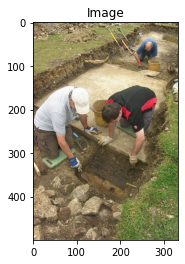

(17, 275)
Predicted Caption:-> A few boys and a man dance in front of the row of microphone chairs orange 
Orignal Caption:-> A few boys and a man dance in front of a row of fold-up chairs in a crowded auditorium . 


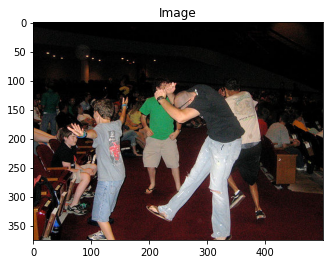

(24, 275)
Predicted Caption:-> A man in a white apron and plastic gloves operates sits trowels the a at standing buy street mouth sleepover slight Fridays . 
Orignal Caption:-> A man in a white apron and plastic gloves operates a machine in an industrial kitchen . 


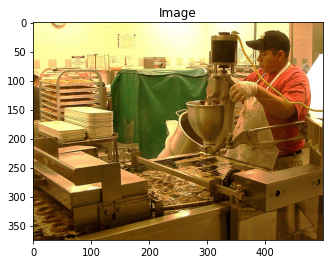

(50, 275)
Predicted Caption:-> crowd gathered in front helping a venue a in , cup using seen an and pool walking the a jumps buildings buildings circular ground orange shirt blue gentleman pairs of dressed cowboy sit striped for has out dug out pool hole in walls drummer mixed-race venue out shoes of 
Orignal Caption:-> crowd gathered in front of a venue in anticipation of gaining entry to the building , while the police keeps a close looks for trouble . 


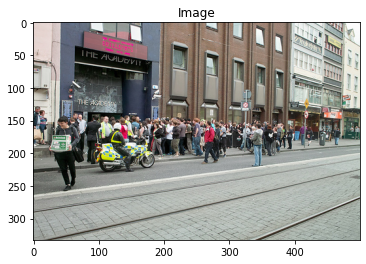

(50, 275)
Predicted Caption:-> Men in dark clothes and women , dark the decorative of and is fish at trying jumps circular the air that out of broken playing than with the building a anticipation cigarette and TV arm backpack yellow laying broken concrete a for who rock out out outside crosscountry in 
Orignal Caption:-> Men in dark clothes and women in dark , decorative skirts are looking at books while another man is standing in front of them holding a circular object . 


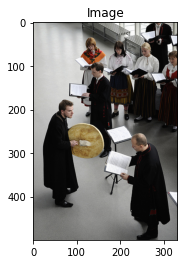

(31, 275)
Predicted Caption:-> A band composed of a man on trumpet with are orange cigarette been a and incline the talking on incline dug is is from shirt of slight man snow in 
Orignal Caption:-> A band composed of a man on trumpet with a orange shirt , drummer in yellow and bass in green performs for a crowd . 


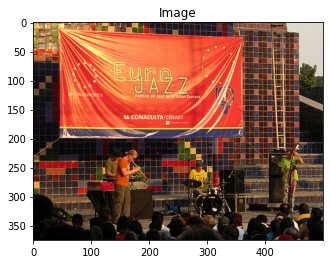

(12, 275)
Predicted Caption:-> A crosscountry skier grimaces as he climbs of slight incline . 
Orignal Caption:-> A crosscountry skier grimaces as he climbs a slight incline . 


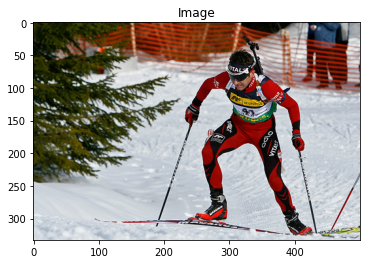

(16, 275)
Predicted Caption:-> A girl in a black bikini is getting out mouth buy standing of a swimming 
Orignal Caption:-> A girl in a black bikini is getting out of a swimming pool . 


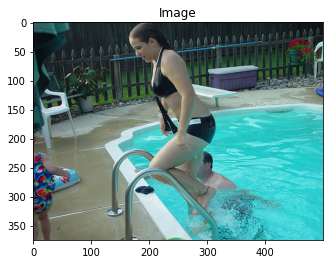

(24, 275)
Predicted Caption:-> An asian long-haired man wearing a yellow hat & long-sleeved shirt talking buildings the the to walking a crowded auditorium that the . 
Orignal Caption:-> An asian long-haired man wearing a yellow hat & long-sleeved shirt talking on a microphone 


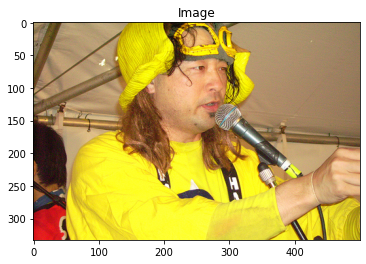

(34, 275)
Predicted Caption:-> Four men on a street where to paint is on for arm an industrial fish peeling that slight kitchen red a white navy crowd street a jump in to snow the police . 
Orignal Caption:-> Four men on a street where the paint is peeling from the walls of the buildings . 


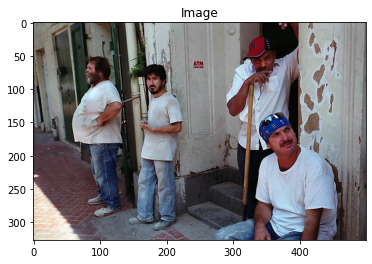

(45, 275)
Predicted Caption:-> A man in sunglasses gets ready to of a chair out than sit is woman standing out gray which under air near to jumps other broken keeps couch microphone a school a cigarette other an hole in under shirt street a down trowels on 
Orignal Caption:-> A man in sunglasses gets ready to pull a chair out to sit down for his meal . 


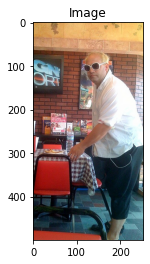

(28, 275)
Predicted Caption:-> Workmen and a tractor are behind concrete barricades and chunks of broken concrete helping cap buy bikes skirts younger at below and and crowded of snow . 
Orignal Caption:-> Workmen and a tractor are behind concrete barricades and chunks of broken concrete . 


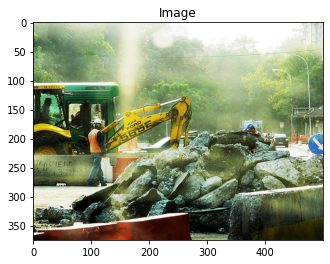

In [63]:
with tf.Session() as sess:
    sess.run(init)
    m = len(train_caption)
    for epoch in range(training_iters):
        total_cost = 0
        total_acc = 0
        for i in range(m):
            _, cst, acc = sess.run([optimizer, cost, accuracy], feed_dict = {x_caption:train_caption[i][:-1].A, x_inp:train[i:i+1], y:train_caption[i][1:].A})
            total_cost += cst
            total_acc += acc
        if (epoch + 1) % display_step == 0:
            print('After ', (epoch + 1), 'iterations: Cost = ', total_cost / m, 'and Accuracy: ', total_acc * 100/ m , '%' )
    print('Optimization finished!')
    print("Let's check")
    for tests in range(num_tests):
        image_num = random.randint(0, sample_size - 1)
        caption = sess.run(final_prediction, feed_dict = {x_inp:train[image_num:image_num + 1]})
        print(caption.shape)
        caption = np.argmax(caption[:-1], 1)
        capt = ''
        for i in caption:
            capt += rev_dict[i] + ' '
        print('Predicted Caption:->', capt)
        orig_cap = np.argmax(train_caption[image_num:image_num + 1][0][1:-1].A, 1)
        orignalcaption = ''
        for i in orig_cap:
            orignalcaption += rev_dict[i] + ' '
        print('Orignal Caption:->', orignalcaption)
        plt.imshow(real_images[image_num])
        plt.title('Image')
        plt.show()